<a href="https://colab.research.google.com/github/ChintPatel/CMPE255-Clustering-Assignment/blob/main/B_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--NAVIGATION-->


<a href="https://colab.research.google.com/github/saskeli/x/blob/master/clustering.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

|                                     -                                     |                                     -                                     |                                     -                                     |
|---------------------------------------------------------------------------|---------------------------------------------------------------------------|---------------------------------------------------------------------------|
|   [Exercise 5 (plant clustering)](<#Exercise-5-(plant-clustering&#41;>)   | [Exercise 6 (nonconvex clusters)](<#Exercise-6-(nonconvex-clusters&#41;>) |      [Exercise 7 (binding sites)](<#Exercise-7-(binding-sites&#41;>)      |



## ML: Clustering

Clustering is one of the types of unsupervised learning. It is similar to classification: the aim is to give a label to each data point. However, unlike in classification, we are not given any examples of labels associated with the data points. We must infer from the data, which data points belong to the same cluster. This can be achieved using some notion of distance between the data points. Data points in the same cluster are somehow close to each other.

One of the simplest clustering methods is the *k-means clustering*. It aims at producing a clustering that is optimal in the following sense:

* the *centre of each cluster* is the average of all points in the cluster
* any point in a cluster is closer to its centre than to a centre of any other cluster

The k-means clustering is first given the wanted number of clusters, say k, as a *hyperparameter*. Next, to start the algorithm, k points from the data set are chosen randomly as cluster centres. Then the following phases are repeated iteratively:

* any data point is set to belong to a cluster, whose centre is closest to it
* then for each cluster a new centre is chosen as the average of the data points in the cluster

This procedure is repeated until the clusters no longer change. This kind of algorithm is called an Expectation-Maximization (EM) algorithm, which is known to converge.

### Simple example

The scikit-learn library has an implementation of the k-means algorithm. Let's apply it to a set of randomly generated blobs, whose labels we throw away.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.datasets import make_blobs
X,y = make_blobs(centers=4, n_samples=200, random_state=0, cluster_std=0.7)
print(X[:10],y[:10])

[[ 2.26403424  1.82613379]
 [-0.97647444  2.59138889]
 [ 1.10046838  4.02254067]
 [-2.82715074  7.11970523]
 [ 1.53393915  0.31915668]
 [ 0.98362009  5.55389667]
 [-1.74452433  2.98606238]
 [ 0.35482006  2.9172298 ]
 [ 1.83747356  5.14545322]
 [ 1.48663347  4.39407536]] [1 2 0 3 1 0 2 0 0 0]


Now we plot these points, but without coloring the points using the labels:

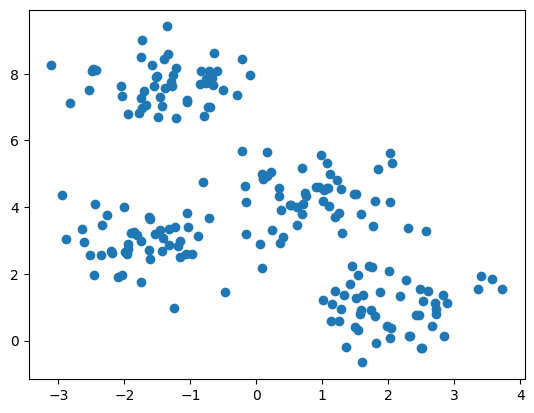

In [ ]:
plt.scatter(X[:,0],X[:,1]);

We can still discern four clusters in the data set. Let's see if the k-means algorithm can recover these clusters. First we create the instance of the k-means model by giving it the number of clusters 4 as a hyperparameter.

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(4)
model.fit(X)
print(model.cluster_centers_)

[[-1.36512238  7.70188306]
 [ 2.07464749  0.9869902 ]
 [-1.64019917  2.91564301]
 [ 0.8965512   4.36602968]]


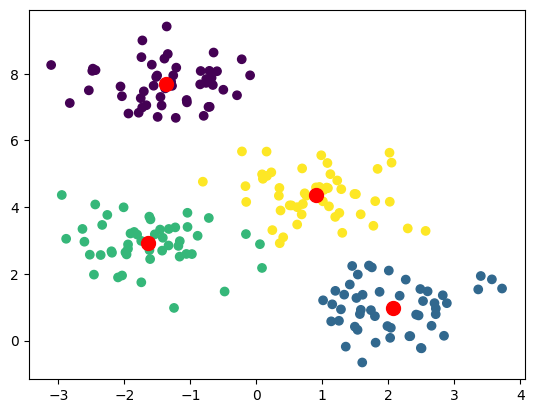

In [ ]:
plt.scatter(X[:,0],X[:,1], c=model.labels_);
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, color="red"); # Show the centres

The clustering looks more or less correct. To get a more quantitative measure of success we can get the accuracy score.

In [ ]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y, model.labels_)
print("Accuracy score is", acc)

Accuracy score is 0.5


Oops! Even though the clusters could match almost perfectly to the original, their labels might be permuted. Let's select randomly one point from each cluster and check their labels from the original data labels. Then we use this label for the whole cluster. In essence, we are renaming the clusters, not re-clustering the data.

In [ ]:
from scipy.stats import mode
import numpy as np

def find_permutation(n_clusters, real_labels, labels):
    permutation = []
    for i in range(n_clusters):
        idx = labels == i
        # Compute the mode
        mode_result = mode(real_labels[idx], axis=None)
        # Explicitly convert mode_result.mode to a numpy array and extract its first element
        new_label = np.array(mode_result.mode).item()
        permutation.append(new_label)
    return permutation

In [ ]:
permutation = find_permutation(4, y, model.labels_)
print(permutation)

[3, 1, 2, 0]


In [ ]:
new_labels = [ permutation[label] for label in model.labels_]   # permute the labels
print("Accuracy score is", accuracy_score(y, new_labels))

Accuracy score is 1.0


So, the k-means algorithm seems to work well in this case, but there can be several problems. Firstly, even though an EM algorithm always converges, it might converge to a local maximum. To avoid this, EM type algorithms are usually run several times, each time starting from different random initial values. For instance, in the scikit-learn implementation, the algorithms is restarted by default 10 times.

### More complicated example

The k-means algorithm can have difficulties when the clusters are not convex shapes:

In [ ]:
from sklearn.datasets import make_moons
X,y = make_moons(200, noise=0.05, random_state=0)

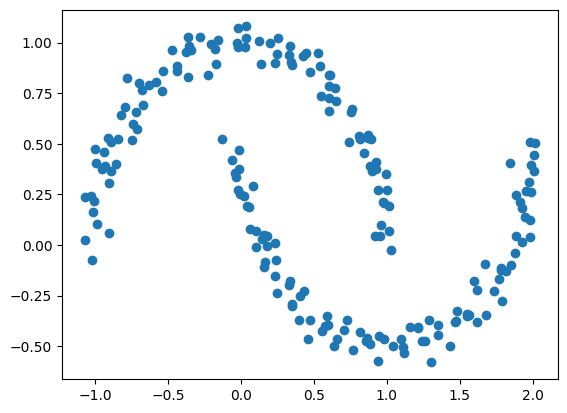

In [ ]:
plt.scatter(X[:,0], X[:,1]);

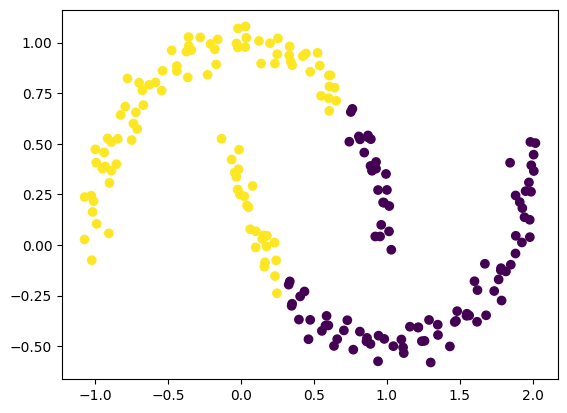

In [ ]:
model=KMeans(2)
model.fit(X)
plt.scatter(X[:,0], X[:,1], c=model.labels_);

The clustering does not work well now, since it is not possible to separate the two clusters with a line. We could embed this data set into a higher dimensional space, where the separation is possible. And then apply the k-means clustering.

Alternatively, we can use a different type of clustering algorithm for this case. The *DBSCAN algorithm* is based on densities and works well on data whose density in the clusters is uniform.

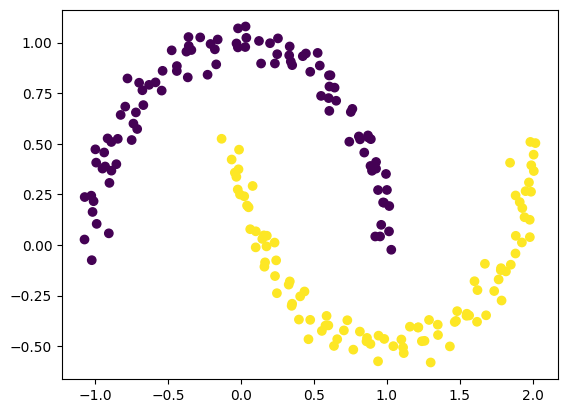

In [ ]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.3)
model.fit(X)
plt.scatter(X[:,0], X[:,1], c=model.labels_);

The good news is that DBSCAN does not require the user to specify the number of clusters. But now the algorithm depends on another hyperparameter: a threshold for distance (here 0.3).

### Clustering digits

Using scikit-learn we can download a set of 1797 images of handwritten digits with the correct labels 0,1,...,9. The images have quite a low resolution: 8*8=64 pixels. Let's see how our machine learning method works with this kind of data.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

To get an idea how these data points look like, we plot first ten of these.

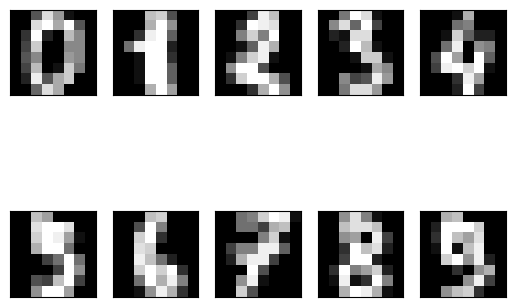

In [ ]:
fig, axes = plt.subplots(2,5, subplot_kw=dict(xticks=[], yticks=[]))
for ax, digit in zip(axes.flat, digits.data[:10]):
    ax.imshow(digit.reshape(8,8), cmap="gray")

Let's cluster these data points into ten clusters.

In [ ]:
model=KMeans(n_clusters = 10, random_state=0)
model.fit(digits.data)
model.cluster_centers_.shape

(10, 64)

So, we have ten cluster centres, which are images with 8x8=64 pixels in them. We can have a look at their appearence:

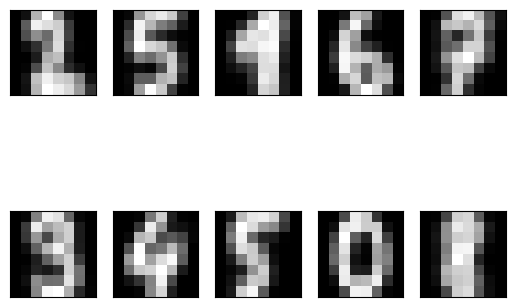

In [ ]:
fig, axes = plt.subplots(2,5, subplot_kw=dict(xticks=[], yticks=[]))
for ax, digit in zip(axes.flat, model.cluster_centers_):
    ax.imshow(digit.reshape(8,8), cmap="gray")

One can recognize these numbers with the exception of maybe number eight. What is the accuracy score of this clustering?

In [ ]:
permutation3 = find_permutation(10, digits.target, model.labels_)
print(permutation3)
acc = accuracy_score(digits.target, [ permutation3[label] for label in model.labels_])
print("Accuracy score is", acc)

[2, 5, 1, 6, 7, 3, 4, 5, 0, 8]
Accuracy score is 0.7440178074568725


This is quite a good result for such a simple algorithm!

#### <div class="alert alert-info">Exercise 5 (plant clustering)</div>

Using the same iris data set that you saw earlier in the classification, apply k-means clustering with 3 clusters.
Create a function `plant_clustering` that loads the iris data set, clusters the data and returns the accuracy_score.

<hr/>

#### <div class="alert alert-info">Exercise 6 (nonconvex clusters)</div>

This exercise can give four points at maximum!

Read the tab separated file data.tsv from the `src` folder into a DataFrame. The dataset has two features X1 and X2, and the label y. Cluster the feature matrix using DBSCAN with different values for the eps parameter. Use values in `np.arange(0.05, 0.2, 0.05)` for clustering. For each clustering, collect the accuracy score, the number of clusters, and the number of outliers. Return these values in a DataFrame, where columns and column names are as in the below example.

Note that DBSCAN uses label -1 to denote outliers , that is, those data points that didn't fit well in any cluster. You have to modify the find_permutation function to handle this: ignore the outlier data points from the accuracy score computation. In addition, if the number of clusters is not the same as the number of labels in the original data, set the accuracy score to NaN.

         eps   Score  Clusters  Outliers                             
    0    0.05      ?         ?         ?
    1    0.10      ?         ?         ?
    2    0.15      ?         ?         ?
    3    0.20      ?         ?         ?

Before submitting the solution, you can plot the data set (with clusters colored) to see what kind of data we are dealing with.

Points are given for each correct column in the result DataFrame.
<hr/>

### Hierarchical clustering

Hierarchical clustering works by first putting each data point in their own cluster and then merging clusters based on some rule, until there are only the wanted number of clusters remaining. For this to work, there needs to be a distance measure between the data points. With this distance measure `d`, we can define another distance measure between the **clusters** U and V using one of the following methods (*linkages*):

* `single`: $d(U, V) := \min_{u \in U, v \in V} d(u,v)$
* `complete`: $d(U, V) := \max_{u \in U, v \in V} d(u,v)$
* `average`: $d(U, V) := \sum_{u \in U, v \in V} \frac{d(u,v)}{|U||V|}$
* `ward`: tries to minimize the variance in each cluster

At each iteration of the algorithm two clusters that are closest to each other are merged. After this the distance between the clusters are recomputed, and then it continues to the next iteration.

Below is an example with a botanical dataset with 150 samples from three species. Each species appears in the dataset 50 times. Each sample point has 4 features, which are basically dimensions of the "leaves" of the flower.

We use the [seaborn](https://seaborn.pydata.org/index.html) library to both to compute the clustering and to visualize the result. The visualization consists of two parts: the *heatmap*, whose rows and/or columns may be reordered so as to have the elements of the same cluster next to each other; and the *dendrogram*, which shows the way the clusters were merged. The colors give the length of the corresponding features.

['setosa' 'versicolor' 'virginica']


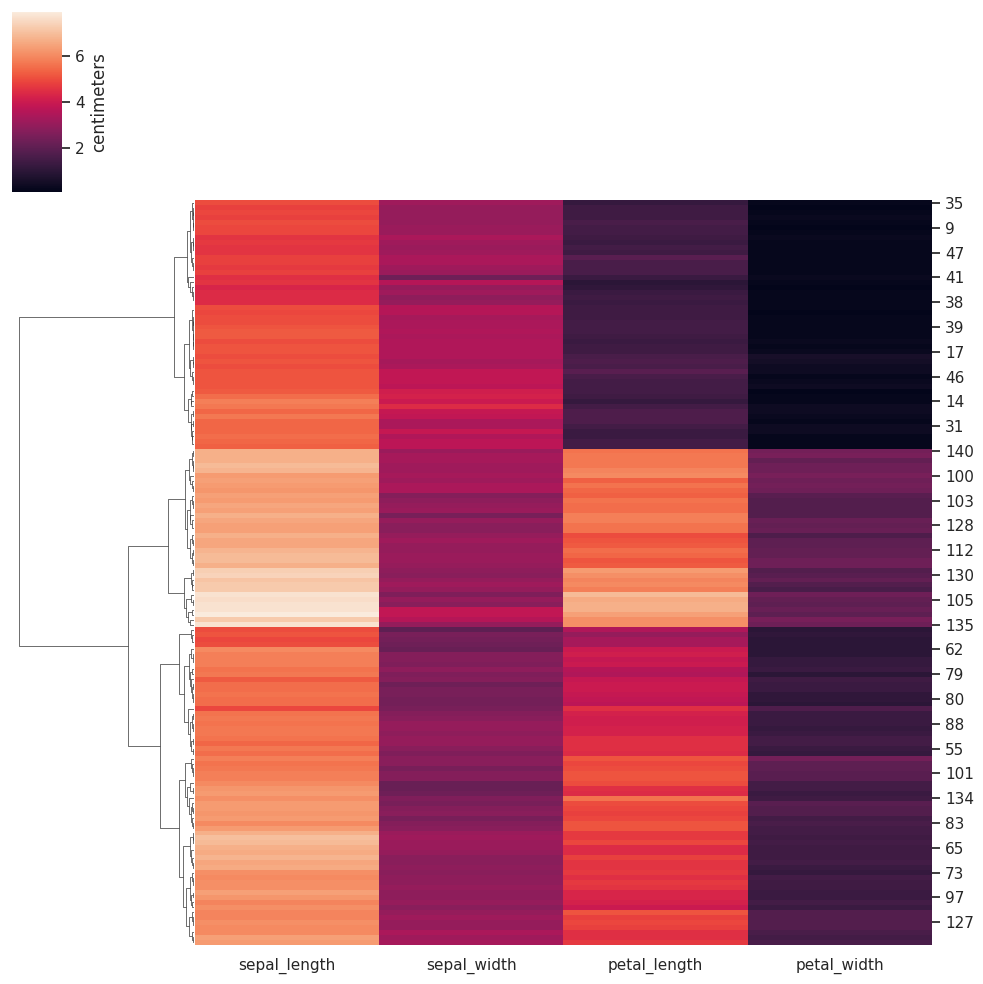

In [ ]:
import seaborn as sns; sns.set(color_codes=True)
iris = sns.load_dataset("iris")
species = iris.pop("species")   # Remove the species column
print(species.unique())         # The samples seems to be from these three species
sns.clustermap(iris, method="ward", col_cluster=False, cbar_kws={'label': 'centimeters'}); # Cluster only the rows
#plt.colorbar().ax.set_title('This is a title')
#plt.gca().images[-1].colorbar.ax.set_title("title")


With sharp eye and good will one can discern three clusters in the above heatmap and dendrogram.

#### <div class="alert alert-info">Exercise 7 (binding sites)</div>

This exercise can give three points at maximum!

A binding site is a piece of DNA where a certain protein prefers to bind. The piece of DNA can be described as a string consisting of letters A, C, G, and T, which correspond to nucleotides Adenine, Cytosine, Guanine, and Thymine.
In this exercise the length of binding sites is eight nucleotides. They are stored in the file `data.seq`,
and the binding sites there are classified into two classes.

Part 1. Write function `toint` that converts a nucleotide to an integer. Use the following mapping:
```
A -> 0
C -> 1
G -> 2
T -> 3
```

Write also function `get_features_and_labels` that gets a filename as a parameter. The function should load the contents of the file into a DataFrame. The column `X` contains a string. Convert this column into a feature matrix using the above `toint` function. For example the column `["GGATAATA","CGATAACC"]` should result to the feature matrix
```
[[2,2,0,3,0,0,3,0],
[1,2,0,3,0,0,1,1]]
```
The function should return a pair, whose first element is the feature matrix and the second element is the label vector.

Part 2. Create function `cluster_euclidean` that gets a filename as parameter. Get the features and labels using the function from part 1. Perform hierarchical clustering using the function `sklearn.cluster.AgglomerativeClustering`. Get two clusters using `average` linkage and `euclidean` affinity. Fit the model and predict the labels. Note that you may have to use the `find_permutation` function again, because even though the clusters are correct, they may be labeled differently than the real labels given in `data.seq`. The function should return the accuracy score.

Part 3. Create function `cluster_hamming` that works like the function in part 2, except now using the [hamming](https://en.wikipedia.org/wiki/Hamming_distance) affinity. Even though it is possible to pass the function `hamming` to `AgglomerativeClustering`, let us now compute the Hamming distance matrix explicitly. We can achieve this using the function `sklearn.metrics.pairwise_distances`. Use the affinity parameter `precomputed` to `AgglomerativeClustering`. And give the distance matrix you got from `pairwise_distances`, instead of the feature matrix, to the `fit_predict` method of the model. If you want, you can visualize the clustering using the provided `plot` function.

Which affinity (or distance) do you think is theoretically more correct of these two (Euclidean or Hamming)? Why?

<!--NAVIGATION-->


<a href="https://colab.research.google.com/github/saskeli/x/blob/master/clustering.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
